In [ ]:
%%capture
!pip install -U pip albumentations==0.4.5 pytorch-lightning
!pip install efficientnet-pytorch
!pip install ipywidgets
!pip install umap-learn
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [ ]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from random import shuffle
import albumentations as A
import torch
import umap
from torch import nn
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchvision.datasets import STL10
import torchvision.transforms.functional as tvf
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from PIL import Image
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from argparse import Namespace
import xml.etree.ElementTree as ET

test_df = pd.read_csv("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Dataset/Cervical Data.csv", usecols=range(1,5))
test_df["Noise"].replace({"0": 0, "1": 1, "Nan": 2}, inplace=True)
test_df.head()
data = list(test_df["Path"])

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
       
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
     
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss
    
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(512,512)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img
    
class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)
    

class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds, labels, target_size=(512,512), debug=False):
        super().__init__()
        self.ds = ds
        self.labels = labels
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomResizedCrop(target_size, scale=(330/512, 330/512), ratio=(1.0, 1.0)),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.6),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5, hue=0.2)
            ], p=0.8)
        ])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw_path = self.ds[idx]
        label = self.labels[idx]
        this_image_raw = Image.open(this_image_raw_path)
        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)
        
        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)
            
        return (t1, t2), torch.tensor(label)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_name("efficientnet-b2")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

hparams = Namespace(
    lr=0.001,
    epochs=200,
    batch_size=27,
    train_size=63580,
    validation_size=7030
)
    
class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hparams = hparams):
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        super().__init__()
        self.hparams.update(vars(hparams))
        self.model = ImageEmbedding()
        self.loss = SupConLoss()
    
    def total_steps(self):
        return len(self.train_dataloader()) // hparams.epochs
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(data,labels,
                                             debug=getattr(hparams, "debug", False)),
                          batch_size=hparams.batch_size, 
                          num_workers=4,#cpu_count(),
                          sampler=SubsetRandomSampler(list(range(hparams.train_size))),
                         drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(data,labels,
                                            debug=getattr(hparams, "debug", False)),
                          batch_size=hparams.batch_size, 
                          shuffle=False,
                          num_workers=4,#cpu_count(),
                          sampler=SequentialSampler(list(range(hparams.train_size + 1, hparams.train_size + hparams.validation_size))),
                         drop_last=True)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        (X, Y), labels = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        z_i = F.normalize(projectionX , dim=1)
        z_j = F.normalize(projectionY, dim=1)
        projX = torch.reshape(z_i,(z_i.shape[0],1,z_i.shape[1]))
        projY = torch.reshape(z_j,(z_j.shape[0],1,z_j.shape[1]))
        features = torch.cat([projX, projY], dim=1)
        loss = self.loss(features=features,labels=labels)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        self.log("loss" if step_name == "train" else loss_key, loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        #"progress_bar": {loss_key: loss}}
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=hparams.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
       }
hparams = Namespace(
    lr=0.001,
    epochs=200,
    batch_size=27,
    train_size=63580,
    validation_size=7030
)

In [ ]:
model = ImageEmbeddingModule.load_from_checkpoint(
    checkpoint_path="/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/model.ckpt"
).eval()

In [5]:
test_df.head()

,Unnamed: 0.1,Path,Noise,Data_type
0,0,/workstation/raid/home/p170059cs/bijoy_backup/...,0,Train
1,1,/workstation/raid/home/p170059cs/bijoy_backup/...,0,Train
2,2,/workstation/raid/home/p170059cs/bijoy_backup/...,0,Train
3,3,/workstation/raid/home/p170059cs/bijoy_backup/...,0,Train
4,4,/workstation/raid/home/p170059cs/bijoy_backup/...,0,Train


In [ ]:
labels = list(test_df["Noise"])

In [6]:
preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
latent_space = []

for path in tqdm(data):
    this_image_raw = Image.open(path)
    img = tvf.resize(this_image_raw, (512,512))
    t1 = preprocess(img)
    t2 = t1.unsqueeze(0)
    embeddings, projections = model(t2)
    projections = projections.cpu().detach().numpy()
    latent_space.append(projections)
latent_space = np.array(latent_space)
latent_space = np.squeeze(latent_space, axis = 1)
print(latent_space.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8209/8209 [57:13<00:00,  2.39it/s]

(8209, 1024)


In [ ]:
latent_space = np.array(latent_space)
latent_space = np.squeeze(latent_space, axis = 1)
image_features_arr = np.rollaxis(latent_space,1,0)
np.savetxt('feature_vectors_samples1.txt',image_features_arr)
pickle.dump(image_features_arr, open('feature_vectors_samples1.pkl', 'wb'))
np.save("labels1.npy", labels)

In [26]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [27]:
feature_vectors = np.loadtxt('feature_vectors_samples.txt')
labels = np.load('labels.npy')
feature_vectors = np.rollaxis(feature_vectors,1,0)
feature_vectors.shape

(3127, 1024)

In [28]:
X_embedded = TSNE(n_components=2,init='random').fit_transform(feature_vectors)

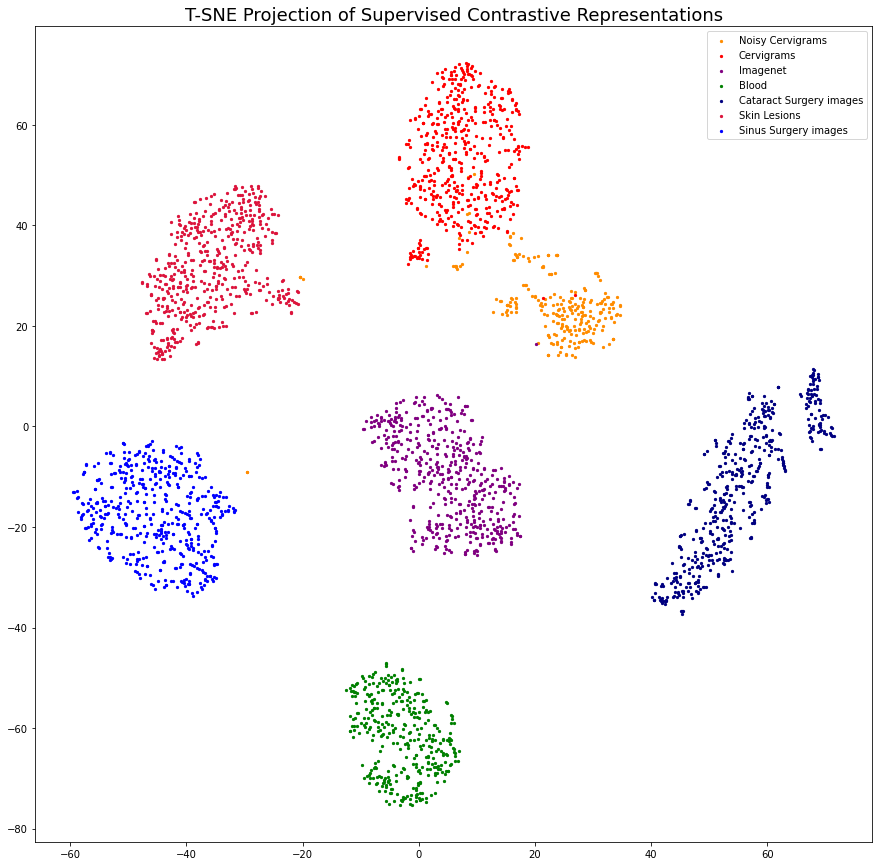

In [29]:
scatter_x = np.array(X_embedded[:,0])
scatter_y = np.array(X_embedded[:,1])
group = np.array(labels)
cdict = {0: 'darkorange', 1: 'red', 2: 'purple', 3: 'green', 4: 'navy', 5: 'crimson', 6: 'blue'}
class_names = {0: "Noisy Cervigrams", 1:"Cervigrams",2:"Imagenet",3:"Blood",4:"Cataract Surgery images",5:"Skin Lesions",6:"Sinus Surgery images"}

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = class_names[g], s = 5)
ax.legend()
plt.title("T-SNE Projection of Supervised Contrastive Representations", fontsize=18)
plt.savefig("TSNE_CLUSTERING")
plt.show()